In [1]:
import pandas as pd
from pathlib import Path

In [2]:
#import necessary packages and training labels
import numpy as np
import pandas as pd

train_labels = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv', dtype=str)
print(train_labels.shape)


(174464, 2)


In [3]:
train_labels.head()


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [4]:
train_labels.dtypes


id       object
label    object
dtype: object

In [5]:
train_labels['label'] = train_labels['label'].astype(float)


In [6]:
import os
print(len(os.listdir('../input/histopathologic-cancer-detection/train/')))
print(len(os.listdir('../input/histopathologic-cancer-detection/test/')))


174464
45561


In [7]:
len(train_labels)


174464

In [8]:
train_labels['label'].value_counts()


label
0.0    103878
1.0     70586
Name: count, dtype: int64

<Axes: ylabel='count'>

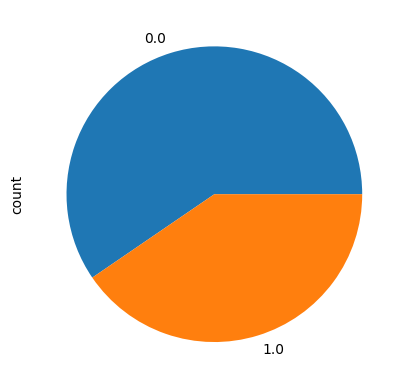

In [9]:
train_labels['label'].value_counts().plot(kind='pie')


In [10]:
#split into two sets based on labels
train_labels_pos = train_labels[train_labels['label']==1]
train_labels_neg = train_labels[train_labels['label']==0]


In [11]:
#take a random sample of the neg labels of the same size as the set of pos labels
train_labels_neg = train_labels_neg.sample(n = train_labels_pos.shape[0])


In [12]:
#confirm both sets are of the same size
print(train_labels_neg.shape[0])
print(train_labels_pos.shape[0])


70586
70586


In [13]:
#combine and randomize the two sets
train_labels_balanced = pd.concat([train_labels_neg,train_labels_pos]).sample(frac=1, random_state=12345).reset_index(drop=True)
train_labels_balanced.head()


,id,label
0,cd15e6c8d3552fa4583141ee5b0a1171446c23d1,1.0
1,8c0a73ad9a1e31ecfc45ce8a2fd45655a64502e9,0.0
2,1e3f97dc5c075b4bc316e2af34577cffdea69689,1.0
3,b5074b6034a09301d1975377af08ab769eaf7ba0,1.0
4,a71f15d08376c839c238004f139d5bc5940abbb4,0.0


In [14]:
#confirm final set has the expected amount and shape
train_labels_balanced.shape


(141172, 2)

In [15]:
#confirm final set has the expected value counts
train_labels_balanced['label'].value_counts()


label
1.0    70586
0.0    70586
Name: count, dtype: int64

<Axes: ylabel='count'>

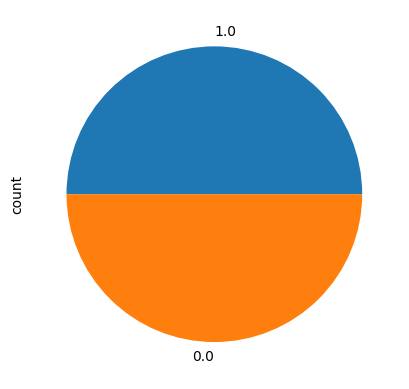

In [16]:
train_labels_balanced['label'].value_counts().plot(kind='pie')


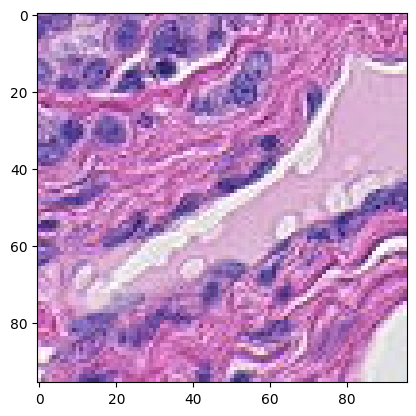

In [17]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(f'../input/histopathologic-cancer-detection/train/{train_labels_balanced.iloc[47,0]}.tif')
imgplot = plt.imshow(img)


In [18]:
print(img.shape)


(96, 96, 3)


In [19]:
sample_imgs = np.random.choice(train_labels_balanced.index,15)


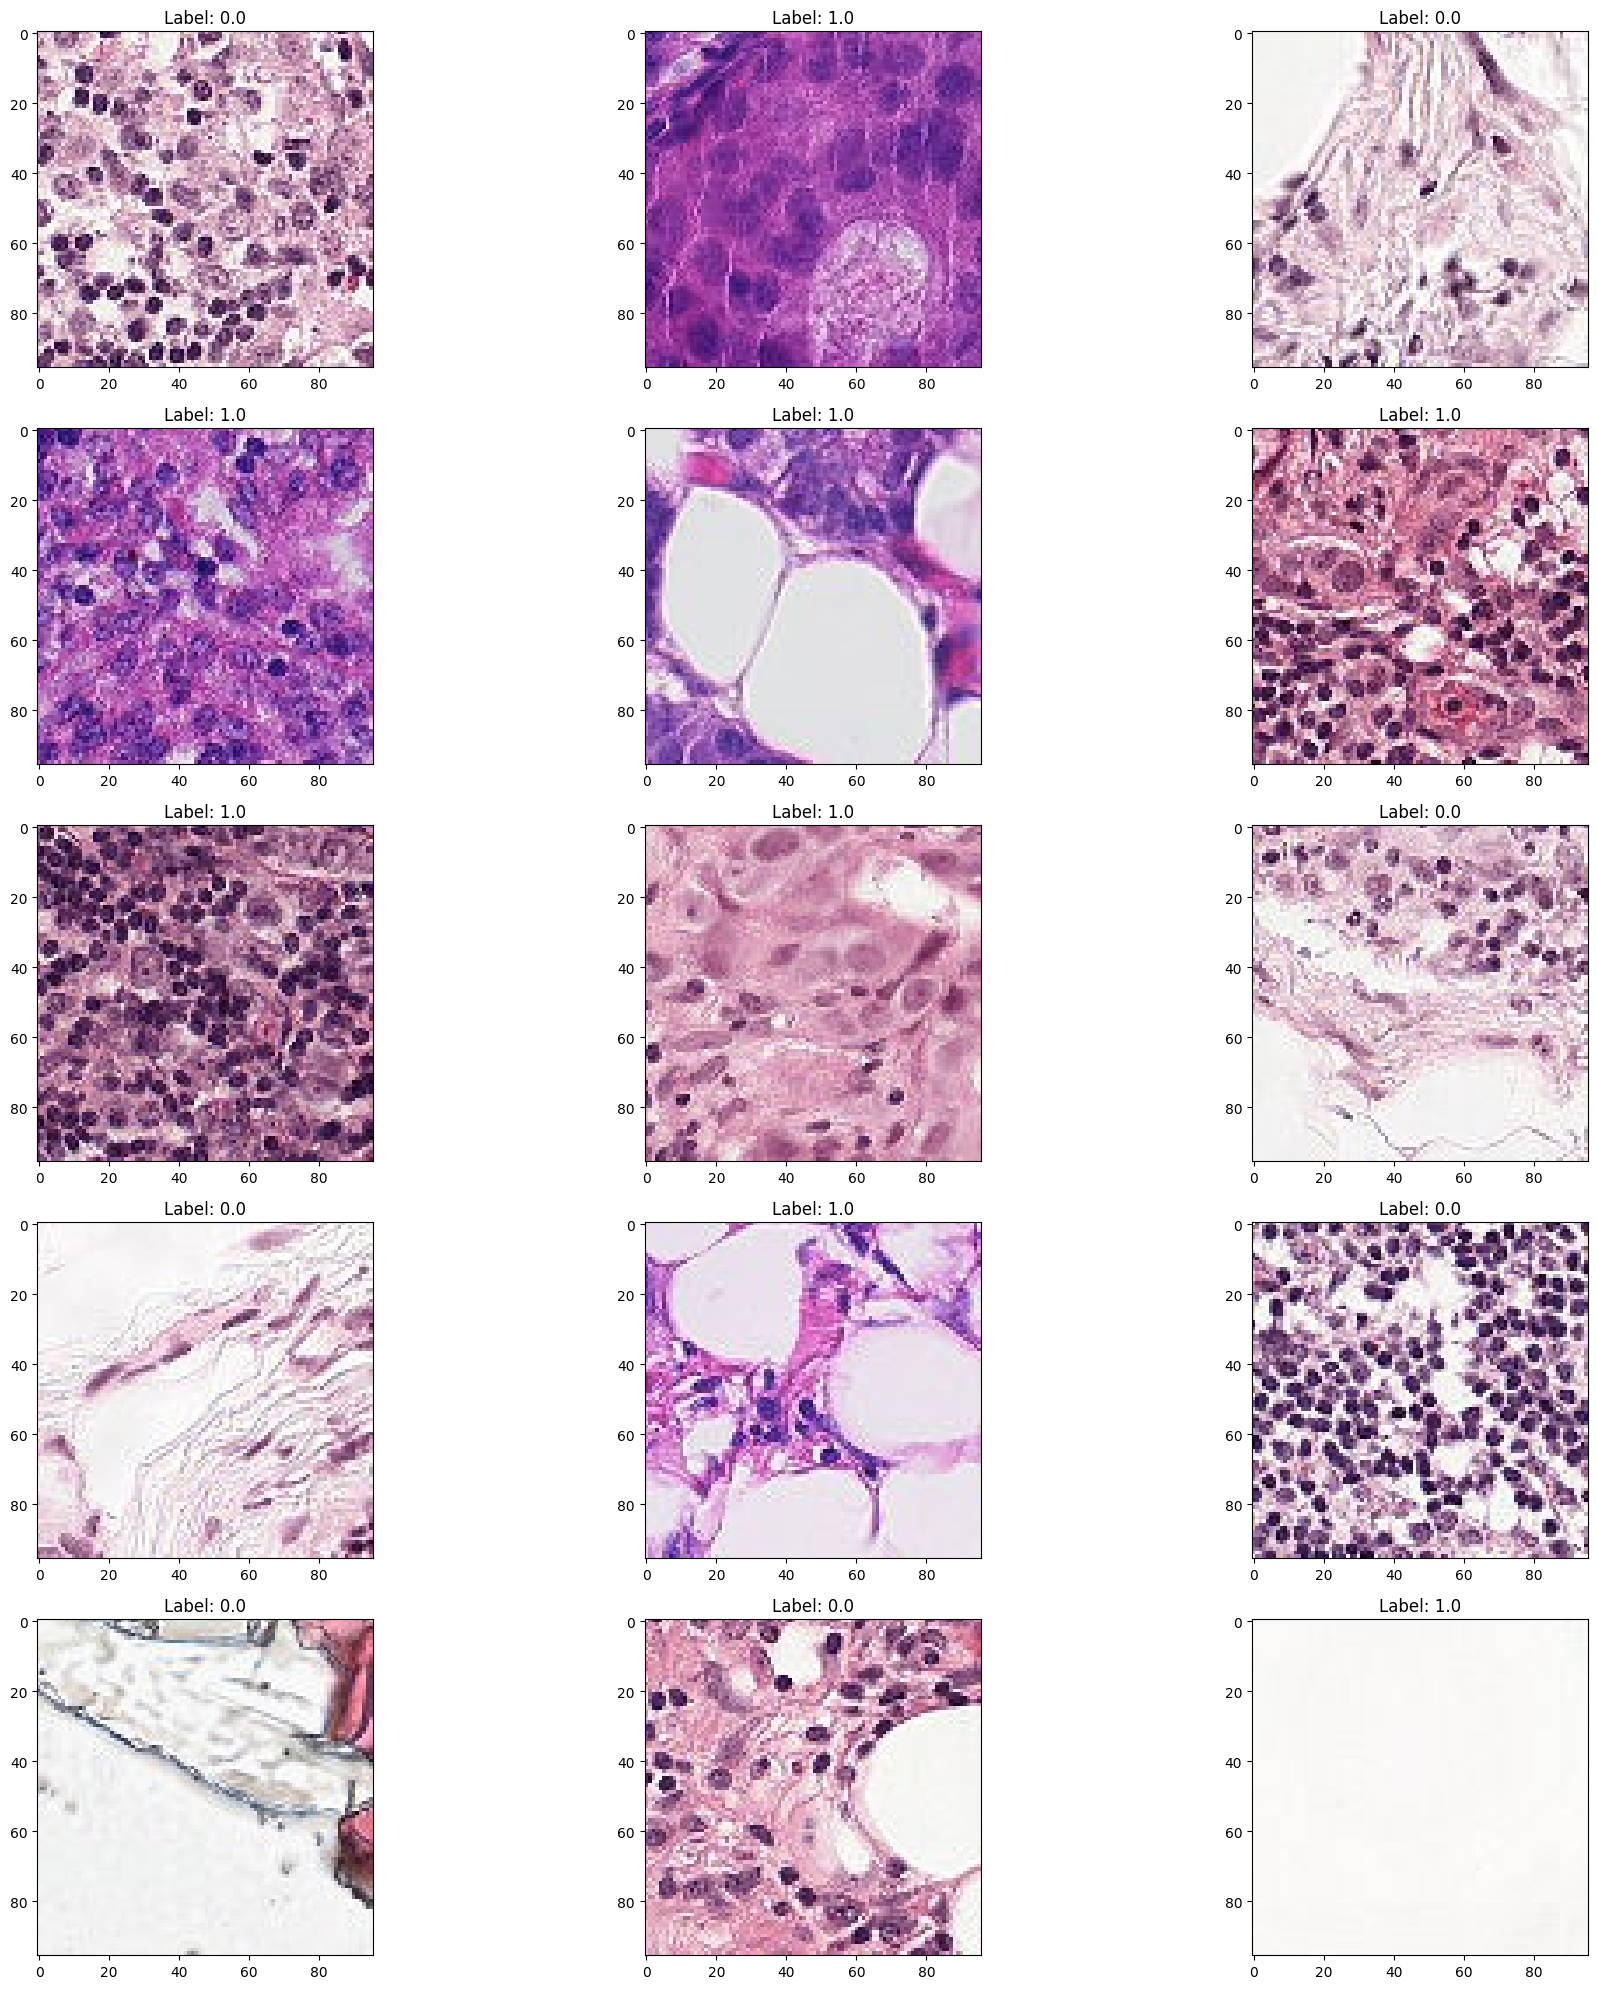

In [20]:
fig, ax = plt.subplots(5, 3,figsize=(20,20))

for i in range(0, sample_imgs.shape[0]):
    ax = plt.subplot(5, 3, i+1)
    img = mpimg.imread(f'../input/histopathologic-cancer-detection/train/{train_labels_balanced.iloc[sample_imgs[i],0]}.tif')
    ax.imshow(img)
    lab = train_labels_balanced.iloc[sample_imgs[i],1]
    ax.set_title('Label: %s'%lab)
    
plt.tight_layout()


In [21]:
from sklearn.model_selection import train_test_split


In [22]:
train_df, valid_df = train_test_split(train_labels_balanced, test_size=0.25, random_state=1234, stratify=train_labels_balanced.label)


In [23]:
#import tensorflow and keras as well as any necessary packages
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow import keras
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.layers import PReLU
from keras.initializers import Constant

from tensorflow.keras.preprocessing.image import ImageDataGenerator


2025-08-17 05:18:53.841963: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755407933.855765       9 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755407933.859966       9 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-17 05:18:53.875777: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
train_df['id'] = train_df['id']+'.tif'
valid_df['id'] = valid_df['id']+'.tif'


In [25]:
train_df['label'] = train_df['label'].astype(str)
valid_df['label'] = valid_df['label'].astype(str)


In [26]:
#create the training and validation subsets
train_datagen=ImageDataGenerator(rescale=1/255)

train_generator=train_datagen.flow_from_dataframe(dataframe=train_df,directory="../input/histopathologic-cancer-detection/train/",
                x_col="id",y_col="label",batch_size=64,seed=1234,shuffle=True,
                class_mode="binary",target_size=(96,96))

valid_generator=train_datagen.flow_from_dataframe(dataframe=valid_df,directory="../input/histopathologic-cancer-detection/train/",
                x_col="id",y_col="label",batch_size=64,seed=1234,shuffle=True,
                class_mode="binary",target_size=(96,96))


Found 105879 validated image filenames belonging to 2 classes.
Found 35293 validated image filenames belonging to 2 classes.


In [27]:
#initial model with 4 sets of 2 convolutional layers
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=(96,96,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
          
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dropout(0.25))
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.25))
model.add(Dense(64))
model.add(Activation('relu')) 

model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-17 05:19:31.467976: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [28]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 94, 94, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 94, 94, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 47, 47, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 43, 43, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 17, 17, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,846,817 (7.05 MB)

 Trainable params: 1,845,857 (7.04 MB)

 Non-trainable params: 960 (3.75 KB)

In [29]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=30, verbose=1
)


AttributeError: 'Sequential' object has no attribute 'fit_generator'

In [30]:
#next model with 3 sets of 5 convolutional layers
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), padding='same',input_shape=(96,96,3)))
model2.add(Activation('relu'))
model2.add(Conv2D(32, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(32, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(32, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(32, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(BatchNormalization())

model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(BatchNormalization())

model2.add(Conv2D(128, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(128, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(128, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(128, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(128, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(BatchNormalization())
          
model2.add(Flatten())
model2.add(Dropout(0.25))
model2.add(Dense(512))
model2.add(Activation('relu'))

model2.add(Dropout(0.25))
model2.add(Dense(256))
model2.add(Activation('relu'))

model2.add(Dropout(0.25))
model2.add(Dense(64))
model2.add(Activation('relu')) 

model2.add(Dropout(0.25))
model2.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(0.001)
model2.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


In [31]:
model2.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 94, 94, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 94, 94, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 92, 92, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 92, 92, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 90, 90, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 88, 88, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 88, 88, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 44, 44, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 44, 44, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 42, 42, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 42, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 40, 40, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 38, 38, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 36, 36, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 34, 34, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 34, 34, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 17, 17, 64)     │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 1,607,361 (6.13 MB)

 Trainable params: 1,606,913 (6.13 MB)

 Non-trainable params: 448 (1.75 KB)

In [32]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

history2 = model2.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=30, verbose=1
)


AttributeError: 'Sequential' object has no attribute 'fit_generator'

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


NameError: name 'history' is not defined

In [34]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model2 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


NameError: name 'history2' is not defined

In [35]:
#next model with 3 sets of 5 convolutional layers
model3 = Sequential()
model3.add(Conv2D(32, (3, 3), padding='same',input_shape=(96,96,3)))
model3.add(Activation('relu'))
model3.add(Conv2D(32, (3, 3)))
model3.add(Activation('relu'))
model3.add(Conv2D(32, (3, 3)))
model3.add(Activation('relu'))
model3.add(Conv2D(32, (3, 3)))
model3.add(Activation('relu'))
model3.add(Conv2D(32, (3, 3)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(BatchNormalization())

model3.add(Conv2D(64, (3, 3)))
model3.add(Activation('relu'))
model3.add(Conv2D(64, (3, 3)))
model3.add(Activation('relu'))
model3.add(Conv2D(64, (3, 3)))
model3.add(Activation('relu'))
model3.add(Conv2D(64, (3, 3)))
model3.add(Activation('relu'))
model3.add(Conv2D(64, (3, 3)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(BatchNormalization())

model3.add(Conv2D(128, (3, 3)))
model3.add(Activation('relu'))
model3.add(Conv2D(128, (3, 3)))
model3.add(Activation('relu'))
model3.add(Conv2D(128, (3, 3)))
model3.add(Activation('relu'))
model3.add(Conv2D(128, (3, 3)))
model3.add(Activation('relu'))
model3.add(Conv2D(128, (3, 3)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(BatchNormalization())
          
model3.add(Flatten())
model3.add(Dropout(0.25))
model3.add(Dense(512))
model3.add(Activation('relu'))

model3.add(Dropout(0.25))
model3.add(Dense(256))
model3.add(Activation('relu'))

model3.add(Dropout(0.25))
model3.add(Dense(64))
model3.add(Activation('relu')) 

model3.add(Dropout(0.25))
model3.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.RMSprop(0.001)
model3.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


In [36]:
model3.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_23 (Conv2D)              │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_29 (Activation)      │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 94, 94, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_30 (Activation)      │ (None, 94, 94, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 92, 92, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_31 (Activation)      │ (None, 92, 92, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 90, 90, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_32 (Activation)      │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 88, 88, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_33 (Activation)      │ (None, 88, 88, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 44, 44, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 44, 44, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 42, 42, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_34 (Activation)      │ (None, 42, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 40, 40, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_35 (Activation)      │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 38, 38, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_36 (Activation)      │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 36, 36, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_37 (Activation)      │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 34, 34, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_38 (Activation)      │ (None, 34, 34, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 17, 17, 64)     │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 1,607,361 (6.13 MB)

 Trainable params: 1,606,913 (6.13 MB)

 Non-trainable params: 448 (1.75 KB)

In [37]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

history3 = model3.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=30, verbose=1
)


AttributeError: 'Sequential' object has no attribute 'fit_generator'

In [38]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model3 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


NameError: name 'history3' is not defined

In [39]:
#next model with 3 sets of 5 convolutional layers, using prelu activations
model4 = Sequential()
model4.add(Conv2D(32, (3, 3), padding='same',input_shape=(96,96,3)))
model4.add(PReLU(alpha_initializer=Constant(value=0.25)))
model4.add(Conv2D(32, (3, 3)))
model4.add(PReLU(alpha_initializer=Constant(value=0.25)))
model4.add(Conv2D(32, (3, 3)))
model4.add(PReLU(alpha_initializer=Constant(value=0.25)))
model4.add(Conv2D(32, (3, 3)))
model4.add(PReLU(alpha_initializer=Constant(value=0.25)))
model4.add(Conv2D(32, (3, 3)))
model4.add(PReLU(alpha_initializer=Constant(value=0.25)))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(BatchNormalization())

model4.add(Conv2D(64, (3, 3)))
model4.add(PReLU(alpha_initializer=Constant(value=0.25)))
model4.add(Conv2D(64, (3, 3)))
model4.add(PReLU(alpha_initializer=Constant(value=0.25)))
model4.add(Conv2D(64, (3, 3)))
model4.add(PReLU(alpha_initializer=Constant(value=0.25)))
model4.add(Conv2D(64, (3, 3)))
model4.add(PReLU(alpha_initializer=Constant(value=0.25)))
model4.add(Conv2D(64, (3, 3)))
model4.add(PReLU(alpha_initializer=Constant(value=0.25)))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(BatchNormalization())

model4.add(Conv2D(128, (3, 3)))
model4.add(PReLU(alpha_initializer=Constant(value=0.25)))
model4.add(Conv2D(128, (3, 3)))
model4.add(PReLU(alpha_initializer=Constant(value=0.25)))
model4.add(Conv2D(128, (3, 3)))
model4.add(PReLU(alpha_initializer=Constant(value=0.25)))
model4.add(Conv2D(128, (3, 3)))
model4.add(PReLU(alpha_initializer=Constant(value=0.25)))
model4.add(Conv2D(128, (3, 3)))
model4.add(PReLU(alpha_initializer=Constant(value=0.25)))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(BatchNormalization())
          
model4.add(Flatten())
model4.add(Dropout(0.25))
model4.add(Dense(512))
model4.add(PReLU(alpha_initializer=Constant(value=0.25)))

model4.add(Dropout(0.25))
model4.add(Dense(256))
model4.add(PReLU(alpha_initializer=Constant(value=0.25)))

model4.add(Dropout(0.25))
model4.add(Dense(64))
model4.add(PReLU(alpha_initializer=Constant(value=0.25)))

model4.add(Dropout(0.25))
model4.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.RMSprop(0.001)
model4.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


In [40]:
model4.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_38 (Conv2D)              │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu (PReLU)                 │ (None, 96, 96, 32)     │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 94, 94, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_1 (PReLU)               │ (None, 94, 94, 32)     │       282,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 92, 92, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_2 (PReLU)               │ (None, 92, 92, 32)     │       270,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 90, 90, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_3 (PReLU)               │ (None, 90, 90, 32)     │       259,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 88, 88, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_4 (PReLU)               │ (None, 88, 88, 32)     │       247,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 44, 44, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 44, 44, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 42, 42, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_5 (PReLU)               │ (None, 42, 42, 64)     │       112,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 40, 40, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_6 (PReLU)               │ (None, 40, 40, 64)     │       102,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 38, 38, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_7 (PReLU)               │ (None, 38, 38, 64)     │        92,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 36, 36, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_8 (PReLU)               │ (None, 36, 36, 64)     │        82,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 34, 34, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_9 (PReLU)               │ (None, 34, 34, 64)     │        73,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 17, 17, 64)     │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 3,510,913 (13.39 MB)

 Trainable params: 3,510,465 (13.39 MB)

 Non-trainable params: 448 (1.75 KB)

In [41]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

history4 = model4.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=30, verbose=1
)


AttributeError: 'Sequential' object has no attribute 'fit_generator'

In [42]:
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('model3 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


NameError: name 'history4' is not defined

In [43]:
test_set = os.listdir('../input/histopathologic-cancer-detection/test/')


In [44]:
test_df = pd.DataFrame(test_set)
test_df.columns = ['id']
test_df.head()


,id
0,7d1637c3535cd849727c50dff5fb0efd42f500a7.tif
1,c66203935db093d22a62c667636345dab7ee67ba.tif
2,f79498aab7f5e43109efb24b3bcc850101102f66.tif
3,697cccea61869921cd992e7bbb111fe26475685a.tif
4,c92685d04e3d905d2db02d608dff7e8226e41a1c.tif


In [45]:
test_datagen=ImageDataGenerator(rescale=1/255)

test_generator=test_datagen.flow_from_dataframe(dataframe=test_df,directory="../input/histopathologic-cancer-detection/test/",
                x_col="id",batch_size=64,seed=1234,shuffle=False,
                class_mode=None,target_size=(96,96))


Found 45561 validated image filenames.


In [46]:
STEP_SIZE_TEST=test_generator.n/2

preds = model4.predict_generator(generator=test_generator,steps=STEP_SIZE_TEST, verbose = 1)


AttributeError: 'Sequential' object has no attribute 'predict_generator'

In [47]:
predictions = []

for pred in preds:
    if pred >= 0.5:
        predictions.append(1)
    else:
        predictions.append(0)
        
predictions[:10]


NameError: name 'preds' is not defined

In [48]:
submission = test_df.copy()
submission['id']=submission['id'].str[:-4]
submission['label']=predictions
submission.head()


ValueError: Length of values (0) does not match length of index (45561)

In [49]:
submission.to_csv('submission.csv',index=False)
